In [4]:
!pip install seaborn

In [5]:
import datetime
import os
from collections import defaultdict
import gc
from joblib import dump, load
import random
import time
from typing import List, Tuple

from albumentations import (
    Compose, Flip, Rotate
)

import dask
import dask.array as da
from google.cloud import storage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, precision_recall_curve

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.metrics import Accuracy

from data_engineering.dask_image_stats_collector import stats_for_numpy_images 

In [6]:
root = '/home/jovyan/work/data/big_earth'
random_seed = 0
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

project_name = "cloud_and_shadow"

In [7]:
import json
# np.array(json.loads(df['binarized_labels'].iloc[0])).shape

def prepare_data(df):
    df['has_cloud_and_shadow_target'] = df['has_cloud_and_shadow_target'].apply(lambda x: np.array(json.loads(x)))
    df['binarized_labels'] = df['binarized_labels'].apply(lambda x: np.array(json.loads(x)))    
    df['image_path'] = root + "/npy_image_files/" + df['image_prefix'] + ".npy"
    return df

df = pd.read_csv(root + "/metadata/metadata.csv")
df = prepare_data(df)
print(df['binarized_labels'].iloc[0].shape)
print(df['has_cloud_and_shadow_target'].iloc[0].shape)
df = df.set_index('image_prefix', drop=False)

(1, 44)
(1,)


In [8]:
# len(pd.read_csv(root + '/google_automl_cloud_and_shadow_dataset.csv'))

google_automl_dataset = pd.read_csv( '/app/data_science/google_automl_cloud_and_shadow_dataset_small.csv')
google_automl_dataset['image_prefix'] = google_automl_dataset['gcs_uri'].str.split('/').apply(lambda x: x[-1].replace(".png", ""))
google_automl_dataset = google_automl_dataset.set_index('image_prefix', drop=False)

train = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TRAIN'].index]
valid = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'VALIDATION'].index]
test = df.loc[google_automl_dataset[google_automl_dataset['set'] == 'TEST'].index]

print(len(train), len(valid), len(test))
print(len(train) + len(valid) + len(test) == len(google_automl_dataset))

1907 253 240
True


In [9]:
if os.path.exists(root + '/cloud_and_shadow_stats.csv'):
    all_stats = pd.read_csv(root + '/cloud_and_shadow_stats.csv')
else:
    stat_list = []
    npy_image_dir = root + "/npy_image_files"
    npy_files = [npy_image_dir + "/" + file + ".npy" for file in train['image_prefix'].values]
    start = time.time()
    stats = stats_for_numpy_images(npy_files,  use_test_data=False)
    stats['data'] = 'all'
    stat_list.append(stats)
    
    # get stats per class
    no_cloud = train[train['has_cloud_and_shadow'] == 0]
    cloud = train[train['has_cloud_and_shadow'] == 1]
    print(len(no_cloud), len(cloud))

    for name, data in [('no_cloud', no_cloud), ('cloud', cloud)]:
        npy_files = [npy_image_dir + "/" + file + ".npy" for file in data['image_prefix'].values]
        stats = stats_for_numpy_images(npy_files,  use_test_data=False)
        stats['data'] = name
        stat_list.append(stats)    
    
    all_stats = pd.concat(stat_list)
    all_stats['band'] = all_stats.index
    all_stats = all_stats.reset_index()  
    all_stats = all_stats.drop('index', axis=1)    
    all_stats.to_csv(root + '/cloud_and_shadow_stats.csv', index=False)
        
    print(f'stats computed in {time.time() - start}')

In [10]:
# no_cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in no_cloud['image_prefix'].values]
# no_cloud_pixels = np.concatenate([np.load(file).reshape(120 * 120, 3) for file in no_cloud_npy_files])
# assert no_cloud_pixels.shape == (len(no_cloud_npy_files) * 120 * 120, 3)

In [11]:
# cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in cloud['image_prefix'].values]
# cloud_pixels = np.concatenate([np.load(file).reshape(120 * 120, 3) for file in cloud_npy_files])

In [12]:
# dfs = []
# for pixels, dataset_name in [(cloud_pixels, 'has_cloud'), (no_cloud_pixels, 'no_cloud')]:
#     for band_name, band_idx in [('red', 0),  ('blue', 1), ('green', 2)]:
#         df = pd.DataFrame({'pixel': cloud_pixels[:, band_idx]})
#         df['band'] = band_name
#         df['dataset'] = dataset_name
#         dfs.append(df)

# pixel_df = pd.concat(dfs)

In [13]:
# pixel_df

In [14]:
# sns.catplot(x="dataset", y="pixel", hue="band", kind="box", data=pixel_df);

In [15]:
all_stats

,mean,std,min,max,data,band,index
0,1037.286040,1904.295943,0,18946,all,red,0
1,1151.790453,1750.604182,0,17921,all,blue,1
2,1104.914808,1826.425950,0,17064,all,green,2
3,826.883167,1639.539906,0,18946,no_cloud,red,3
4,963.876001,1506.040242,0,17921,no_cloud,blue,4
5,958.935820,1606.936217,0,17064,no_cloud,green,5
6,1242.674130,2111.121499,1,17586,cloud,red,6
7,1335.226115,1942.671101,1,16822,cloud,blue,7
8,1247.414504,2007.573214,1,16206,cloud,green,8


In [17]:
all_stats['index'] = all_stats.index
melted = all_stats.drop(['max'], axis=1).melt(value_name='pixel', var_name='stat', id_vars=['index', 'band', 'data'])

<ErrorbarContainer object of 3 artists>

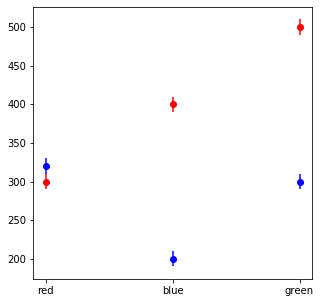

In [18]:
d = pd.DataFrame({'std': [10, 10 , 10],  'mean': [300, 400, 500], 
                  'band': ['red',  'blue', 'green'], 'dataset': ['no_cloud', 'no_cloud', 'no_cloud']})
d2 = pd.DataFrame({'std': [10, 10 , 10],  'mean': [320, 200, 300], 
                  'band': ['red',  'blue', 'green'], 'dataset': ['cloud', 'cloud', 'cloud']})
# plt.scatter(d['band'], d['mean'])
# plt.errorbar(d['band'],d['mean'],yerr=d['std'], linestyle="None")
# plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(d['band'], d['mean'], yerr=d['std'], fmt="-o", mec='r', mfc='r', linestyle="None", label='no cloud', 
            **dict(ecolor='r'))
ax.errorbar(d2['band'], d2['mean'], yerr=d2['std'], fmt="-o", mec='b', mfc='b', linestyle="None", label='cloud', 
            **dict(ecolor='b'))


<ErrorbarContainer object of 3 artists>

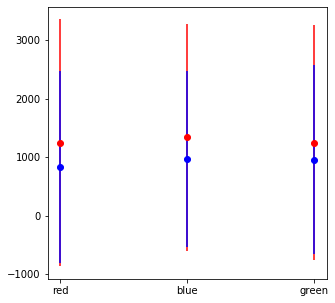

In [19]:
cloud_stats = all_stats[all_stats['data'] == 'cloud']
no_cloud_stats = all_stats[all_stats['data'] == 'no_cloud']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.errorbar(cloud_stats['band'], cloud_stats['mean'], yerr=cloud_stats['std'], fmt="-o", mec='r', mfc='r', linestyle="None", label='cloud', 
            **dict(ecolor='r'))
ax.errorbar(no_cloud_stats['band'], no_cloud_stats['mean'], yerr=no_cloud_stats['std'], fmt="-o", mec='b', mfc='b', linestyle="None", label='no_cloud', 
            **dict(ecolor='b'))

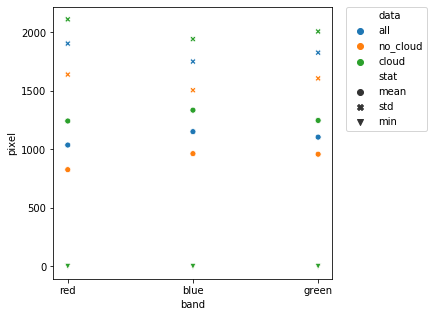

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
s = sns.scatterplot(x='band', y='pixel', hue='data', data=melted, style='stat', 
                markers={'mean': 'o', 'max': '^', 'min': 'v', 'std': 'X'}, 
                ax=ax)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

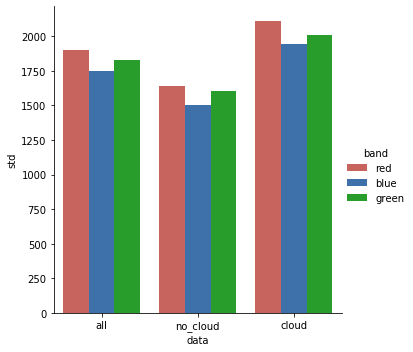

In [46]:
red = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["medium blue"]
green = sns.xkcd_rgb["green"]

sns.catplot(x="data", y="std", hue="band", kind="bar", data=all_stats, 
            palette={'red': red, 'blue': blue, 'green': green}).set_titles('std')

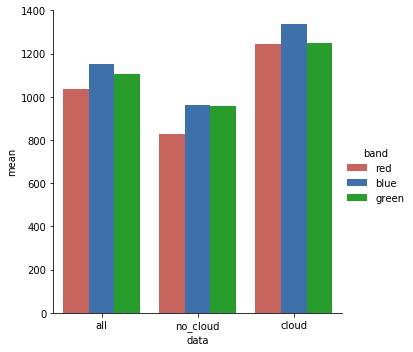

In [47]:
red = sns.xkcd_rgb["pale red"]
blue = sns.xkcd_rgb["medium blue"]
green = sns.xkcd_rgb["green"]

sns.catplot(x="data", y="mean", hue="band", kind="bar", data=all_stats, 
            palette={'red': red, 'blue': blue, 'green': green}).set_titles('mean')

In [ ]:
sns.catplot(x="data", y="min", hue="band", kind="bar", data=all_stats, 
            palette={'red': 'red', 'blue': 'blue', 'green': 'green'}).set_titles('min')

In [ ]:
sns.catplot(x="data", y="max", hue="band", kind="bar", data=all_stats, 
            palette={'red': 'red', 'blue': 'blue', 'green': 'green'}).set_titles('max')

In [ ]:
stats = all_stats[all_stats['data'] == 'all'].set_index('band')
means = np.array(stats['mean'])
stds = np.array(stats['std'])
mins = np.array(stats['min'])
maxs = np.array(stats['max'])

In [ ]:
# https://stackoverflow.com/questions/14464449/using-numpy-to-efficiently-convert-16-bit-image-data-to-8-bit-for-display-with

def display(image, display_min, display_max): # copied from Bi Rico
    image = np.array(image, copy=True)
    image.clip(display_min, display_max, out=image)
    image -= display_min
    np.floor_divide(image, (display_max - display_min + 1) / 256,
                    out=image, casting='unsafe')
    return image.astype(np.uint8)

def lut_display(image, display_min, display_max) :
    lut = np.arange(2**16, dtype='uint16')
    lut = display(lut, display_min, display_max)
    return np.take(lut, image)

In [ ]:
def map_uint16_to_uint8(img, lower_bound=None, upper_bound=None):
    '''
    Map a 16-bit image trough a lookup table to convert it to 8-bit.

    Parameters
    ----------
    img: numpy.ndarray[np.uint16]
        image that should be mapped
    lower_bound: int, optional
        lower bound of the range that should be mapped to ``[0, 255]``,
        value must be in the range ``[0, 65535]`` and smaller than `upper_bound`
        (defaults to ``numpy.min(img)``)
    upper_bound: int, optional
       upper bound of the range that should be mapped to ``[0, 255]``,
       value must be in the range ``[0, 65535]`` and larger than `lower_bound`
       (defaults to ``numpy.max(img)``)

    Returns
    -------
    numpy.ndarray[uint8]
    '''
    if not(0 <= lower_bound < 2**16) and lower_bound is not None:
        raise ValueError(
            '"lower_bound" must be in the range [0, 65535]')
    if not(0 <= upper_bound < 2**16) and upper_bound is not None:
        raise ValueError(
            '"upper_bound" must be in the range [0, 65535]')
    if lower_bound is None:
        lower_bound = np.min(img)
    if upper_bound is None:
        upper_bound = np.max(img)
    if lower_bound >= upper_bound:
        raise ValueError(
            '"lower_bound" must be smaller than "upper_bound"')
    lut = np.concatenate([
        np.zeros(lower_bound, dtype=np.uint16),
        np.linspace(0, 255, upper_bound - lower_bound).astype(np.uint16),
        np.ones(2**16 - upper_bound, dtype=np.uint16) * 255
    ])
    return lut[img].astype(np.uint8)

In [ ]:
# map_uint16_to_uint8(arr, np.min(mins), np.max(maxs))

In [ ]:
###### dim = 3
fig, axs = plt.subplots(dim, dim, **{'figsize': (15,  15)})

no_cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in no_cloud['image_prefix'].values]
for row_num, row_axs in enumerate(axs):
    for col_num, ax in enumerate(row_axs):
        img_num = dim * row_num + col_num
        arr = np.load(no_cloud_npy_files[img_num])
        # normalizing gives a produces images that are too dark
#         rgb_img = ((arr - means) / stds * 256.).astype(np.int8)
        # scaling by 1 std away from the mean seems to do the best
        rgb_img = (arr / (means + 2 * stds) * 256.).astype(np.int8)
        # min max produces images that are all black
#         rgb_img = ((arr - mins) / (maxs - mins) * 256.).astype(np.int8)        
        # dividing by 256 produces images that are too white
#         rgb_img = arr / 256

        ax.imshow(rgb_img)
        text = list(map(lambda x: x.strip(), no_cloud.iloc[img_num]['labels'].replace('\'', '').replace('[', '').replace(']', '').split(',')))
        print(row_num, col_num, text)

In [ ]:
dim = 3
fig, axs = plt.subplots(dim, dim, **{'figsize': (15,  15)})

cloud_npy_files = [npy_image_dir + "/" + file + ".npy" for file in cloud['image_prefix'].values]
for row_num, row_axs in enumerate(axs):
    for col_num, ax in enumerate(row_axs):
        img_num = dim * row_num + col_num * 10 
        arr = np.load(cloud_npy_files[img_num])
        rgb_img = (arr / (means + .75*stds) * 256.).astype(np.int8)
        ax.imshow(rgb_img)
        text = list(map(lambda x: x.strip(), cloud.iloc[img_num]['labels'].replace('\'', '').replace('[', '').replace(']', '').split(',')))
        print(row_num, col_num, text)

In [ ]:
dir(axs[0][0])